In [1]:
# Instala pacotes necessários em silêncio
%pip install -q imbalanced-learn pandas scikit-learn seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importação das Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE, ADASYN

In [3]:
# Configurações de visualização
sns.set_theme(style="whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

**Análise Exploratória dos dados **

In [4]:
# Carregamento dos dados

# URLs dos dados
url_train = "https://raw.githubusercontent.com/pcbrom/perceptron-mlp-cnn/refs/heads/main/data/train.csv"
url_test = "https://raw.githubusercontent.com/pcbrom/perceptron-mlp-cnn/refs/heads/main/data/test.csv"
url_validation = "https://raw.githubusercontent.com/pcbrom/perceptron-mlp-cnn/refs/heads/main/data/validation.csv"

# Leitura dos dados mantendo apenas as 9 primeiras colunas
df_train = pd.read_csv(url_train).iloc[:, :9]
df_test = pd.read_csv(url_test).iloc[:, :9]
df_validation = pd.read_csv(url_validation).iloc[:, :9]

In [5]:
# Visão geral dos dados
for name, df in zip(['Treino', 'Teste', 'Validação'], [df_train, df_test, df_validation]):
    print(f"➡️ Dimensão do dataset de {name.lower()}: {df.shape}")
    display(df.head())

➡️ Dimensão do dataset de treino: (274, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,104,64,37,64,33.6,0.510,22,1
1,3,129,64,29,115,26.4,0.219,28,1
2,6,92,62,32,126,32.0,0.085,46,0
3,1,116,78,29,180,36.1,0.496,25,0
4,1,172,68,49,579,42.4,0.702,28,1


➡️ Dimensão do dataset de teste: (59, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,133,102,28,140,32.8,0.234,45,1
1,2,68,70,32,66,25.0,0.187,25,0
2,1,106,70,28,135,34.2,0.142,22,0
3,11,143,94,33,146,36.6,0.254,51,1
4,2,105,58,40,94,34.9,0.225,25,0


➡️ Dimensão do dataset de validação: (59, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,9,156,86,28,155,34.3,1.189,42,1
1,7,168,88,42,321,38.2,0.787,40,1
2,2,155,52,27,540,38.7,0.240,25,1
3,9,171,110,24,240,45.4,0.721,54,1
4,1,109,38,18,120,23.1,0.407,26,0


/tmp/ipykernel_16242/1654581784.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(bins=30, ax=ax, color="steelblue", grid=False)
/tmp/ipykernel_16242/1654581784.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(bins=30, ax=ax, color="steelblue", grid=False)
/tmp/ipykernel_16242/1654581784.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(bins=30, ax=ax, color="steelblue", grid=False)
/tmp/ipykernel_16242/1654581784.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(bins=30, ax=ax, color="steelblue", grid=False)


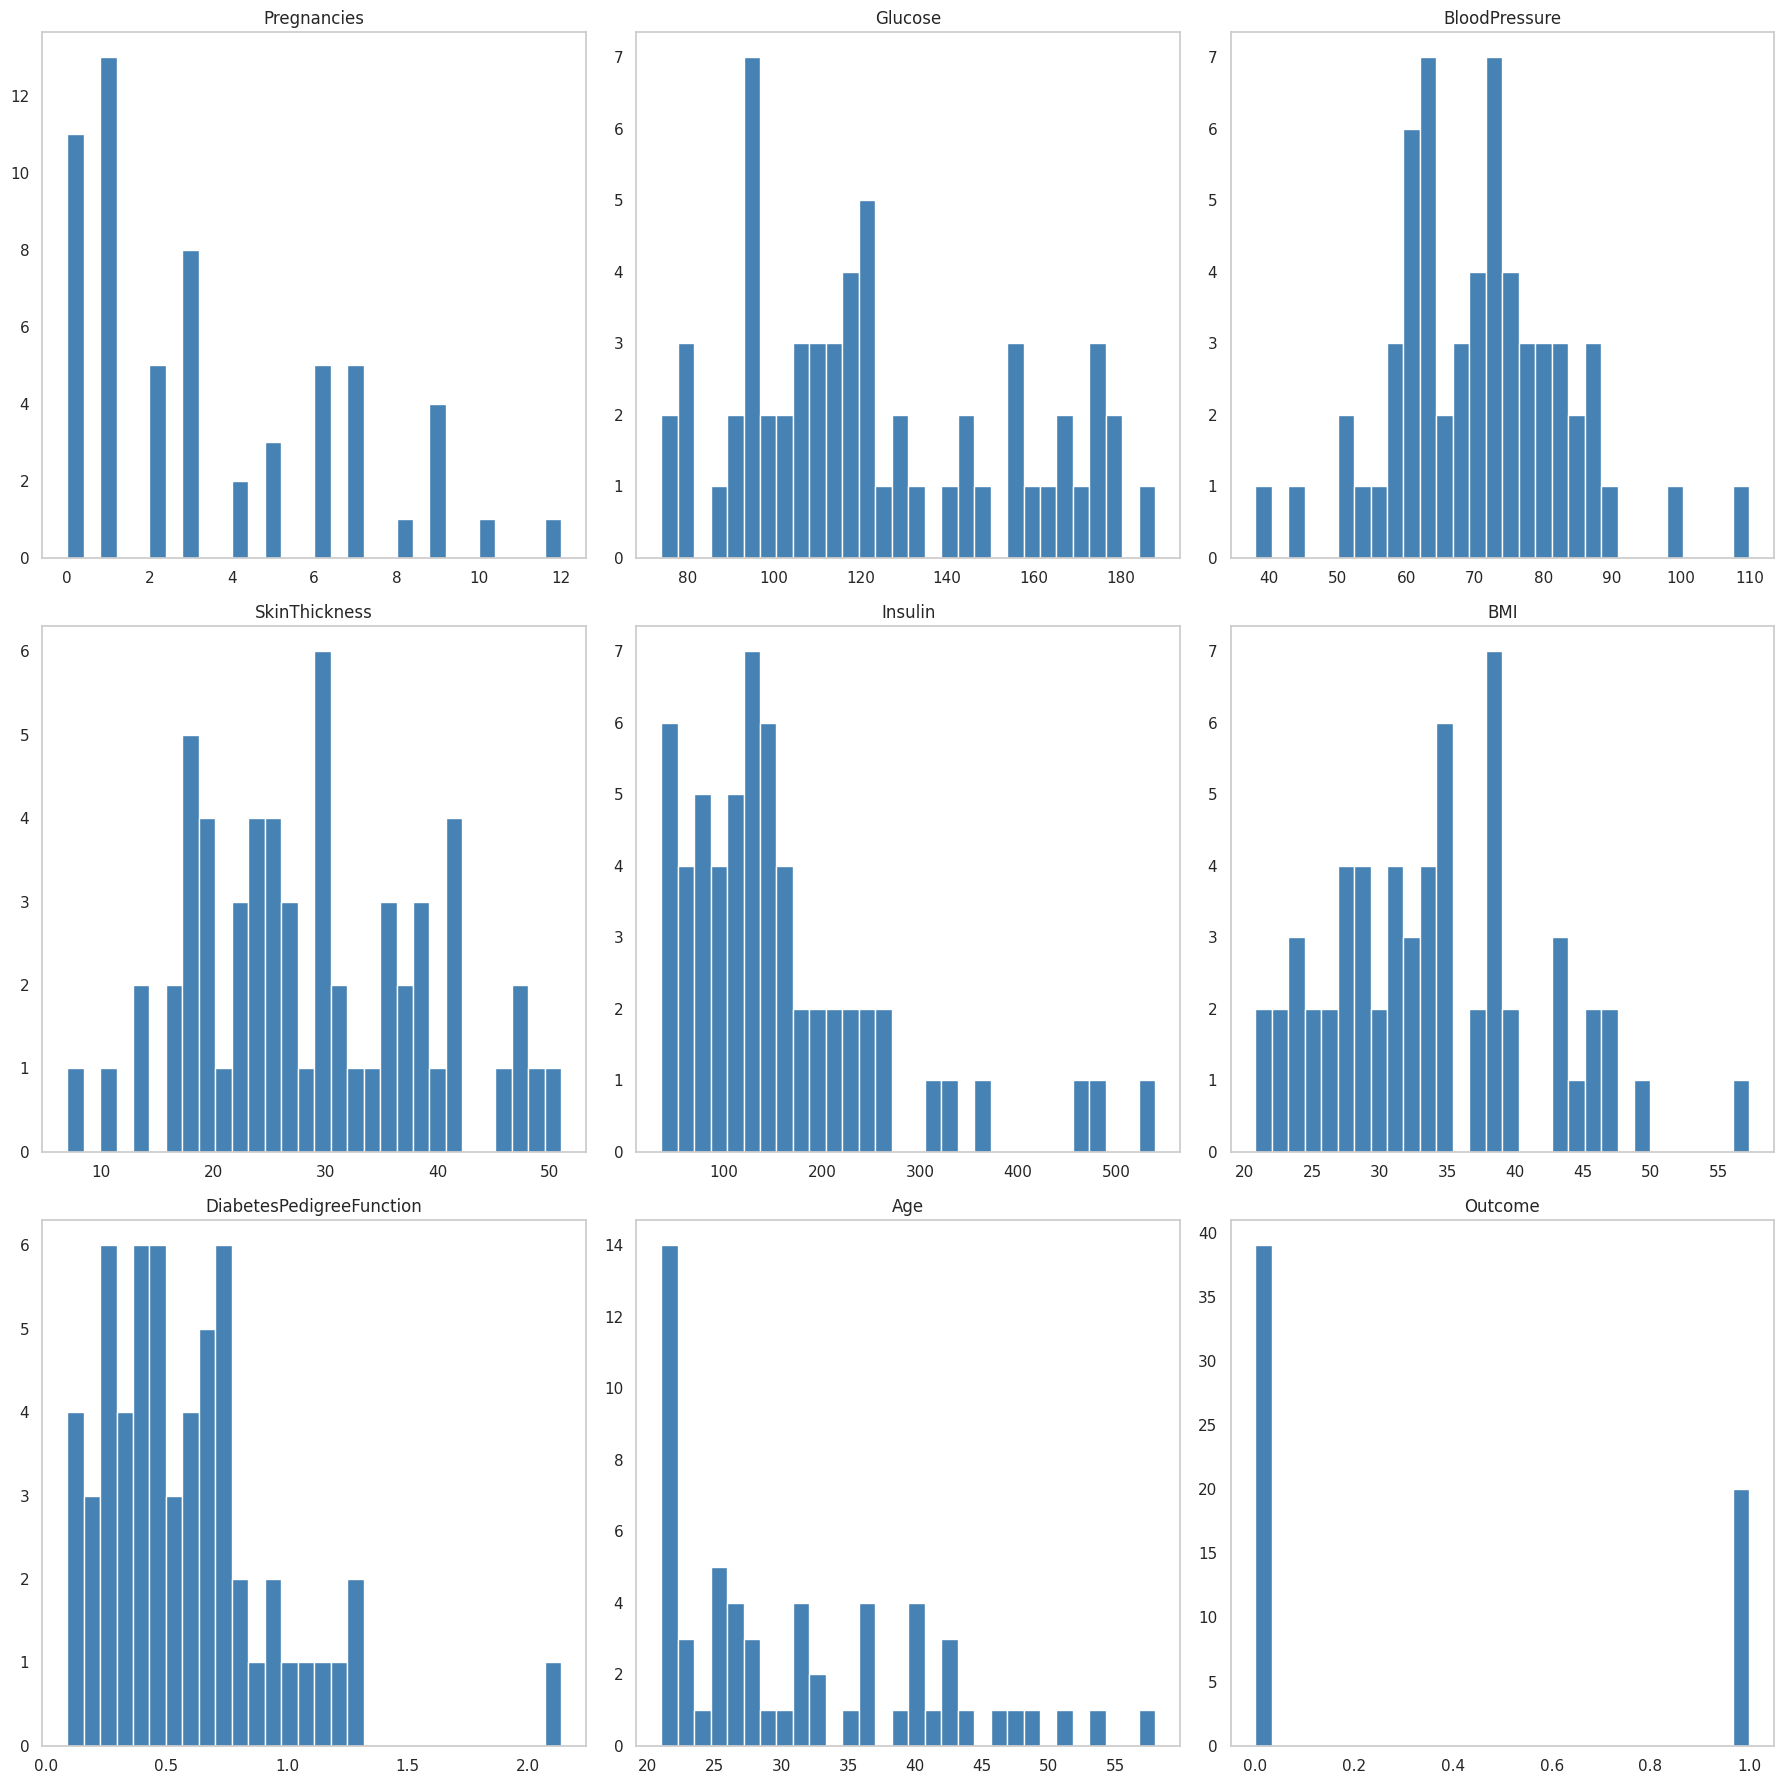

In [6]:
# Histogramas comparativos
fig, axes = plt.subplots(3, 1, figsize=(18, 18))

for ax, df, title in zip(axes, [df_train, df_test, df_validation], ["Treino", "Teste", "Validação"]):
    df.hist(bins=30, ax=ax, color="steelblue", grid=False)
    ax.set_title(f"Distribuição das Variáveis - {title}")

plt.tight_layout()
plt.show()

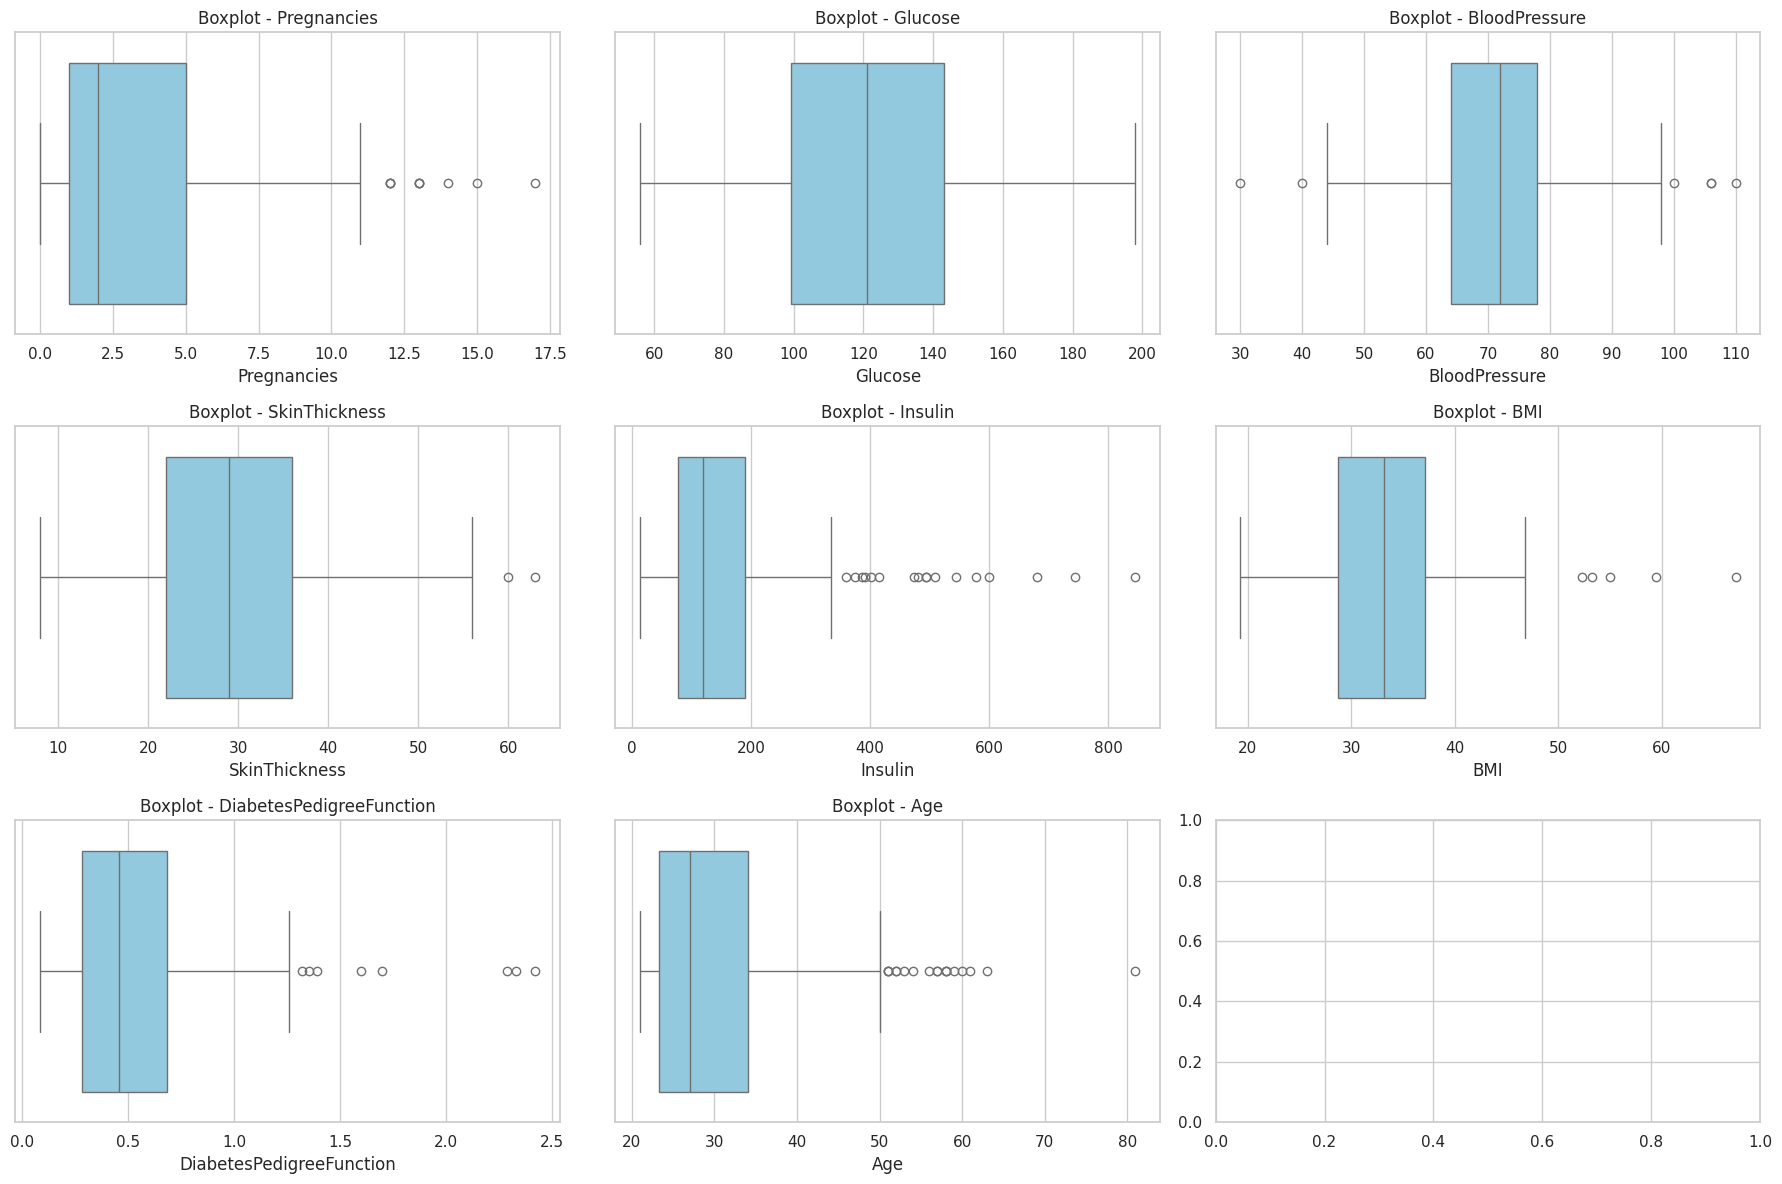

In [7]:
# Boxplots comparativos
num_cols = df_train.select_dtypes(include='number').columns[:-1]

fig, axes = plt.subplots(nrows=len(num_cols)//3 + 1, ncols=3, figsize=(18, 12))

for ax, col in zip(axes.flatten(), num_cols):
    sns.boxplot(x=df_train[col], ax=ax, color="skyblue")
    ax.set_title(f"Boxplot - {col}")

plt.tight_layout()
plt.show()

/home/charles/pca/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


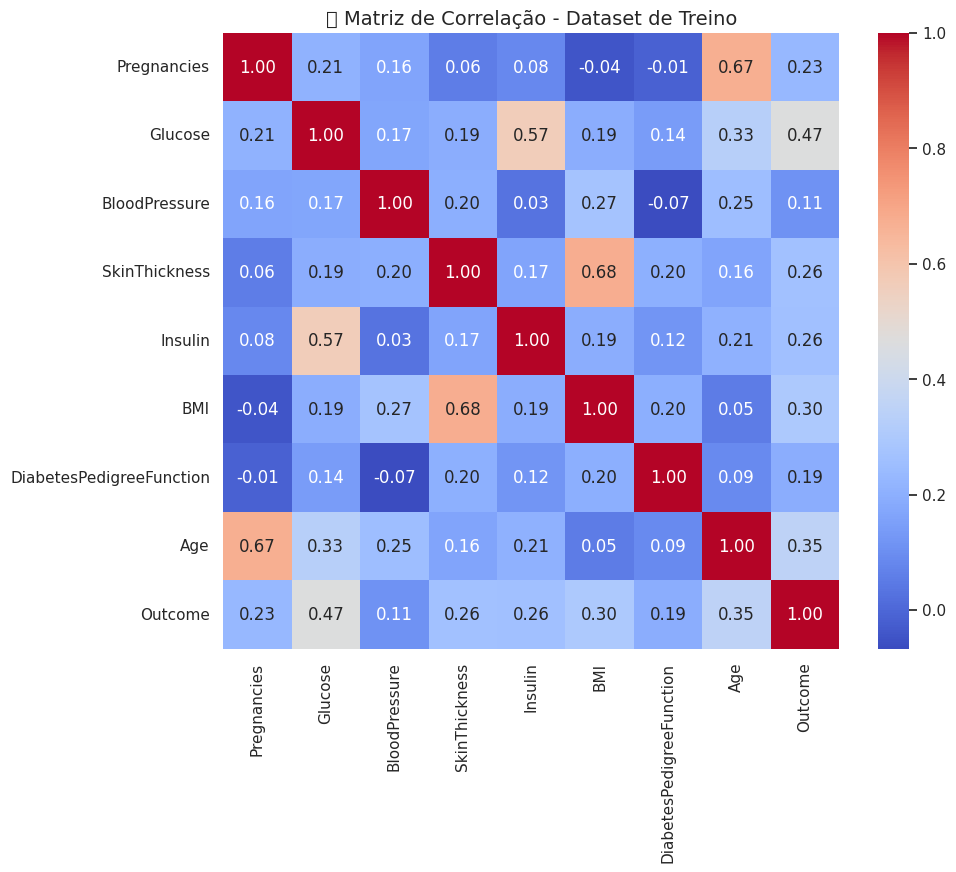

In [8]:
# Matriz de Correlação
plt.figure(figsize=(10, 8))
sns.heatmap(df_train.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("🔍 Matriz de Correlação - Dataset de Treino", fontsize=14)
plt.show()

/tmp/ipykernel_16242/165827733.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Outcome", data=df_train, palette="viridis")


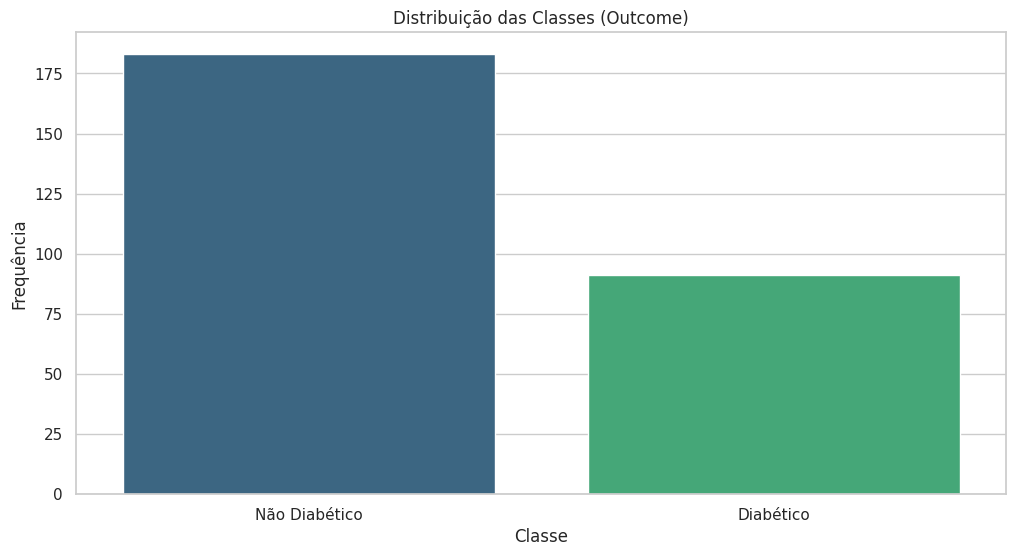

In [9]:
# Distribuição das classes
sns.countplot(x="Outcome", data=df_train, palette="viridis")
plt.title("Distribuição das Classes (Outcome)")
plt.xticks([0, 1], ["Não Diabético", "Diabético"])
plt.xlabel("Classe")
plt.ylabel("Frequência")
plt.show()

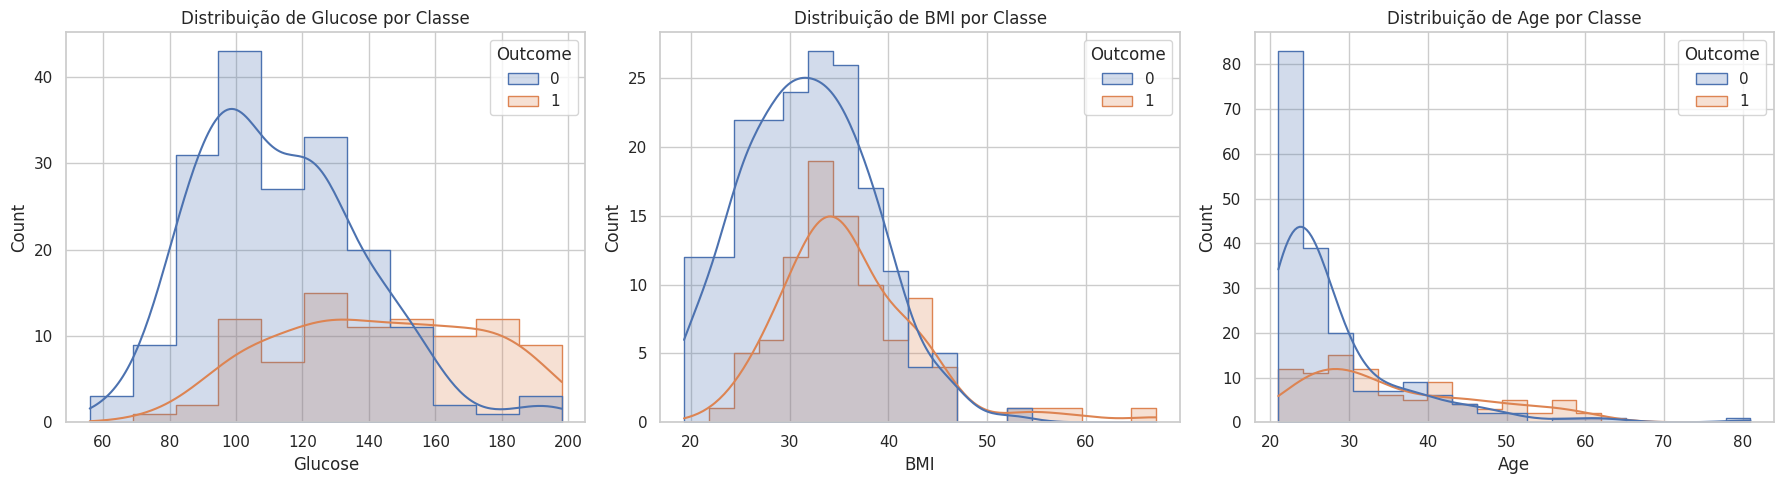

In [10]:
# Distribuição condicional por classe
features_to_plot = ["Glucose", "BMI", "Age"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, feature in zip(axes, features_to_plot):
    sns.histplot(data=df_train, x=feature, hue="Outcome", kde=True, element="step", ax=ax)
    ax.set_title(f"Distribuição de {feature} por Classe")

plt.tight_layout()
plt.show()

**Regressão Logística Sem a Utilização de SMOTE e ADASYN**

SMOTE e ADASYN são métodos de oversampling supervisionado usados antes do treinamento do modelo para balancear datasets desbalanceados.

SMOTE (Synthetic Minority Over-sampling Technique) gera novas amostras sintéticas da classe minoritária.As novas amostras são criadas interpolando entre amostras reais e seus vizinhos mais próximos.Isso evita simplesmente duplicar dados existentes, o que poderia causar overfitting. No dataset em quentão a classe diabéticos é menor que a classe não diabéticos.

**Regressão Logística SEM Utilização de SMOTE e ADASYN. Com Diversos Limiares**

In [11]:
# Imputação dos valores ausentes com a mediana
imputer = SimpleImputer(strategy="median")

# Separação entre features (X) e alvo (y) para cada dataset
X_train = df_train.drop("Outcome", axis=1)
y_train = df_train["Outcome"]

X_test = df_test.drop("Outcome", axis=1)
y_test = df_test["Outcome"]

X_val = df_validation.drop("Outcome", axis=1)
y_val = df_validation["Outcome"]

# Imputação (aplica-se apenas nos dados numéricos)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_val_imputed = imputer.transform(X_val)

# Padronização dos dados
scaler = StandardScaler()

# Ajuste e transformação apenas nos dados de treino
X_train_scaled = scaler.fit_transform(X_train_imputed)

# Transformação nos dados de teste e validação (sem ajuste)
X_test_scaled = scaler.transform(X_test_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [12]:
# Treinamento do modelo de regressão logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Probabilidades previstas para o conjunto de teste
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Apenas a probabilidade da classe positiva (1)

In [13]:
# Avaliação para múltiplos limiares
thresholds = np.arange(0.1, 0.91, 0.05)
resultados = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)  # Classifica com base no limiar
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    resultados.append((thresh, precision, recall, f1))

# DataFrame com os resultados
df_limiar = pd.DataFrame(resultados, columns=["Limiar", "Precisão", "Recall", "F1-Score"])

# Exibindo os resultados
print("\nAvaliação por múltiplos limiares:")
display(df_limiar)


Avaliação por múltiplos limiares:


/home/charles/pca/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Limiar,Precisão,Recall,F1-Score
0,0.10,0.487179,1.000000,0.655172
1,0.15,0.513514,1.000000,0.678571
2,0.20,0.593750,1.000000,0.745098
3,0.25,0.642857,0.947368,0.765957
4,0.30,0.680000,0.894737,0.772727
5,0.35,0.700000,0.736842,0.717949
6,0.40,0.666667,0.631579,0.648649
7,0.45,0.625000,0.526316,0.571429
8,0.50,0.692308,0.473684,0.562500
9,0.55,0.818182,0.473684,0.600000


In [14]:
# Seleção do melhor limiar com base no F1-score
melhor_limiar = df_limiar.loc[df_limiar["F1-Score"].idxmax(), "Limiar"]
print(f"\nMelhor limiar com base no F1-score: {melhor_limiar:.2f}")


Melhor limiar com base no F1-score: 0.30


In [15]:
# Predição final com limiar otimizado
y_pred_final = (y_proba >= melhor_limiar).astype(int)

# Avaliação Final com Limiar Otimizado
print("\nAvaliação Final com Limiar Otimizado:")
print("Acurácia:", accuracy_score(y_test, y_pred_final))
print("Precisão:", precision_score(y_test, y_pred_final))
print("Revocação (Recall):", recall_score(y_test, y_pred_final))
print("F1-score:", f1_score(y_test, y_pred_final))


Avaliação Final com Limiar Otimizado:
Acurácia: 0.8305084745762712
Precisão: 0.68
Revocação (Recall): 0.8947368421052632
F1-score: 0.7727272727272727


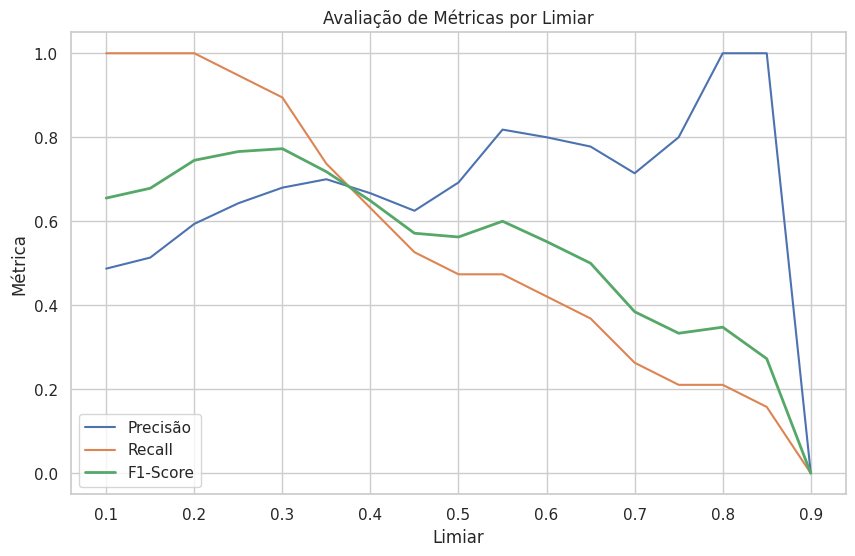

In [16]:
# Plot das métricas por limiar
plt.figure(figsize=(10, 6))
plt.plot(df_limiar["Limiar"], df_limiar["Precisão"], label="Precisão")
plt.plot(df_limiar["Limiar"], df_limiar["Recall"], label="Recall")
plt.plot(df_limiar["Limiar"], df_limiar["F1-Score"], label="F1-Score", linewidth=2)
plt.xlabel("Limiar")
plt.ylabel("Métrica")
plt.title("Avaliação de Métricas por Limiar")
plt.legend()
plt.grid(True)
plt.show()

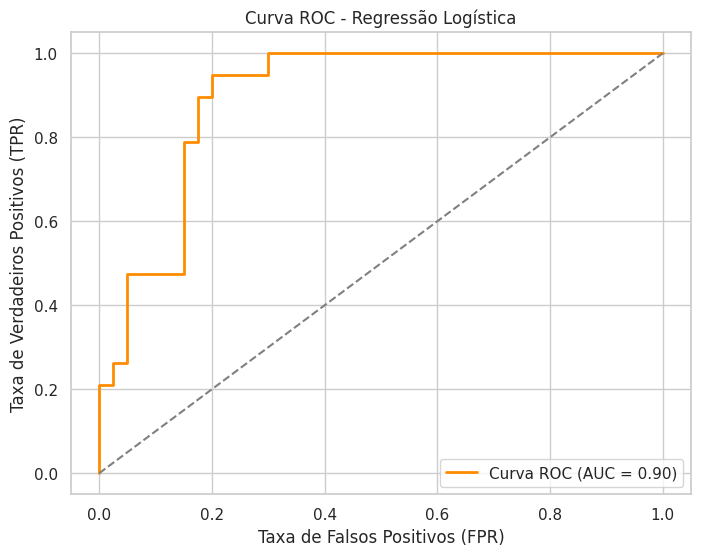

In [17]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Regressão Logística")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()